Using device: cuda
    dataset hidden_layers  learning_rate activation optimizer  epochs  \
0  2_og.csv      [23, 23]           0.01       relu      adam      50   

   avg_f1_score  
0           1.0  


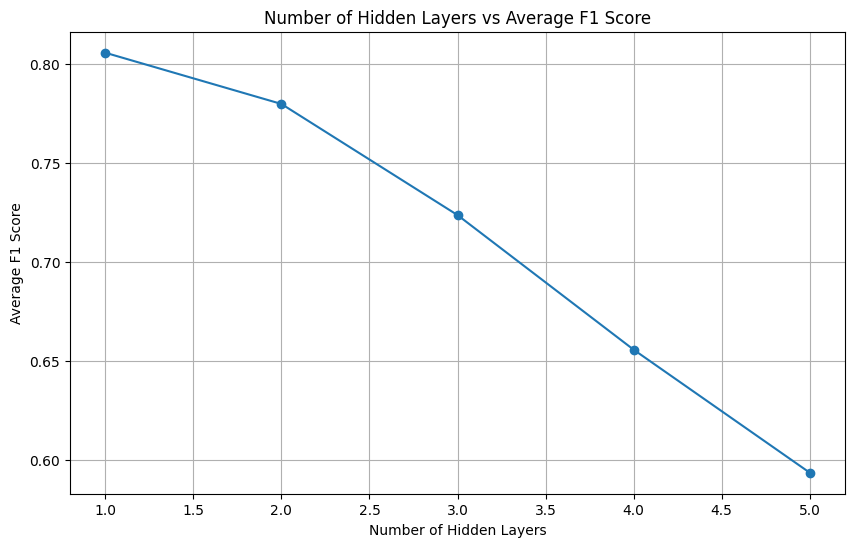


Average F1-Score by Number of Hidden Layers:
 num_hidden_layers  avg_f1_score
                 1      0.805780
                 2      0.779885
                 3      0.723711
                 4      0.655669
                 5      0.593484


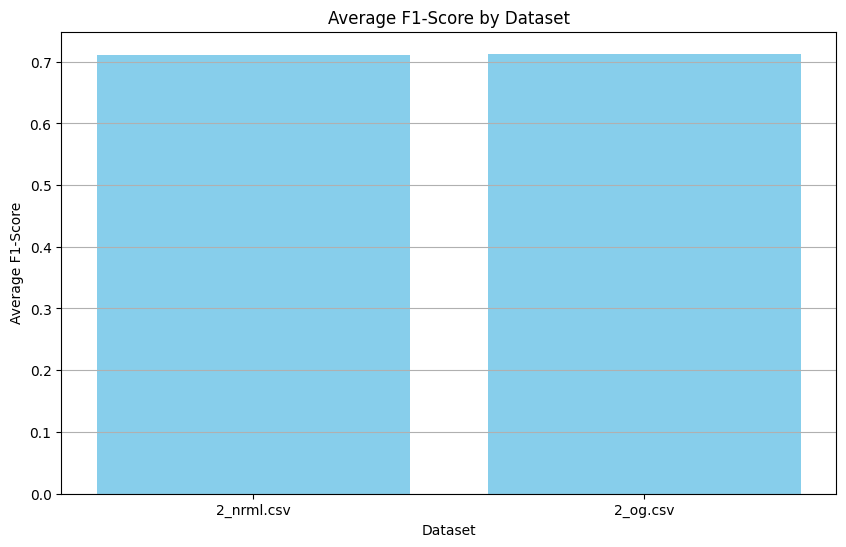


Average F1-Score by Dataset:
   dataset  avg_f1_score
2_nrml.csv      0.710498
  2_og.csv      0.712914


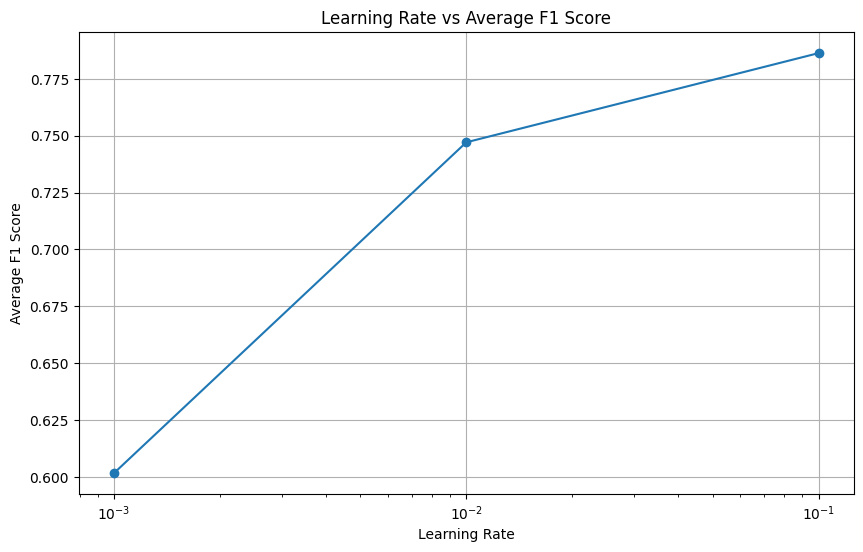


Average F1-Score by Learning Rate:
 learning_rate  avg_f1_score
         0.001      0.601743
         0.010      0.747094
         0.100      0.786281


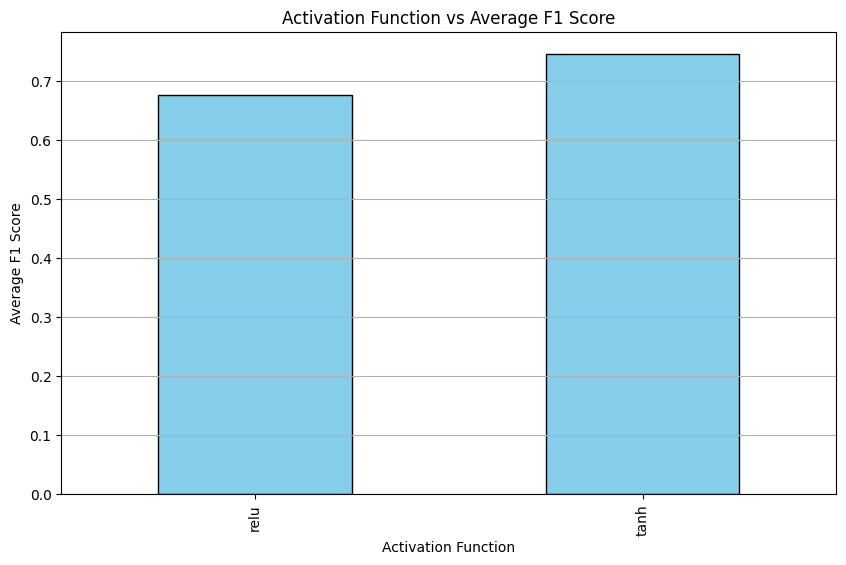


Average F1-Score by Activation Function:
activation  avg_f1_score
      relu      0.677455
      tanh      0.745957


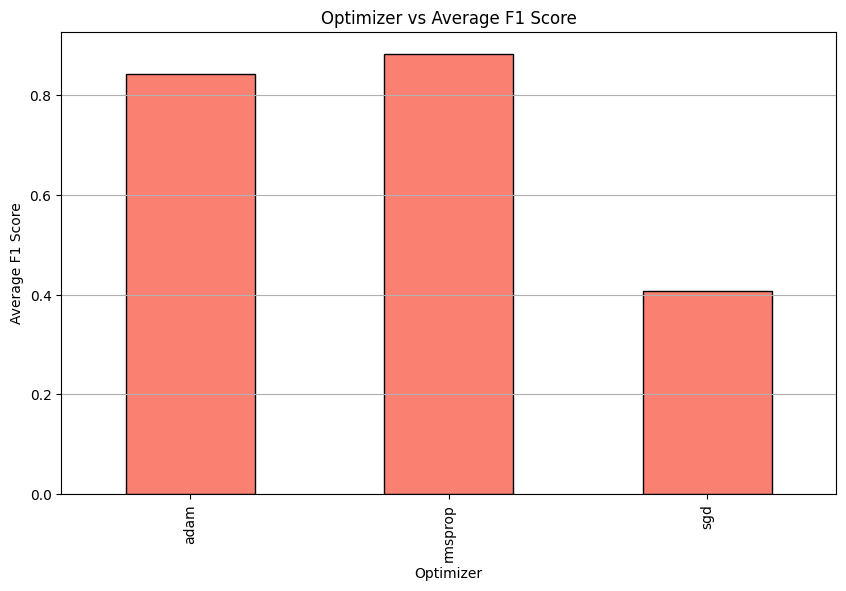


Average F1-Score by Optimizer:
optimizer  avg_f1_score
     adam      0.843836
  rmsprop      0.883381
      sgd      0.407900


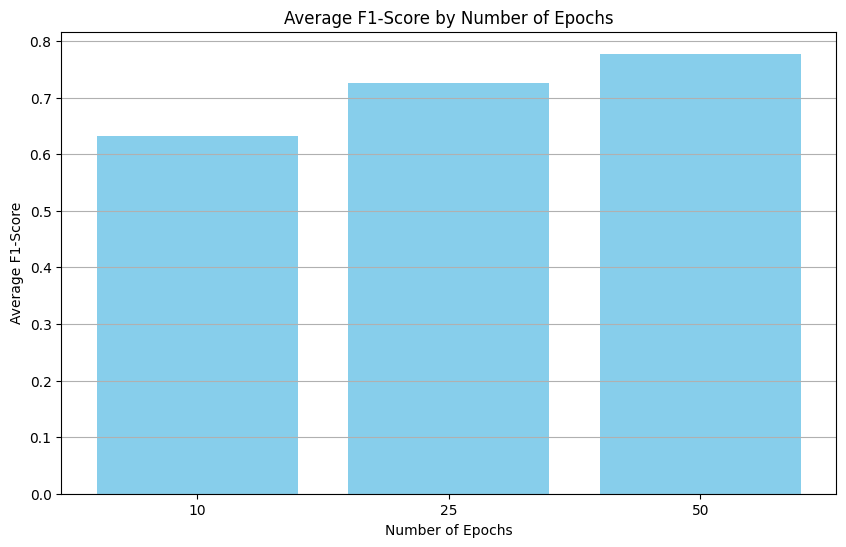


Average F1-Score by Number of Epochs:
 epochs  avg_f1_score
     10      0.632440
     25      0.725080
     50      0.777598

Top 3 Configurations based on Average F1-Score:
 dataset hidden_layers  learning_rate activation optimizer  epochs  avg_f1_score
2_og.csv      [23, 23]           0.01       relu      adam      50           1.0


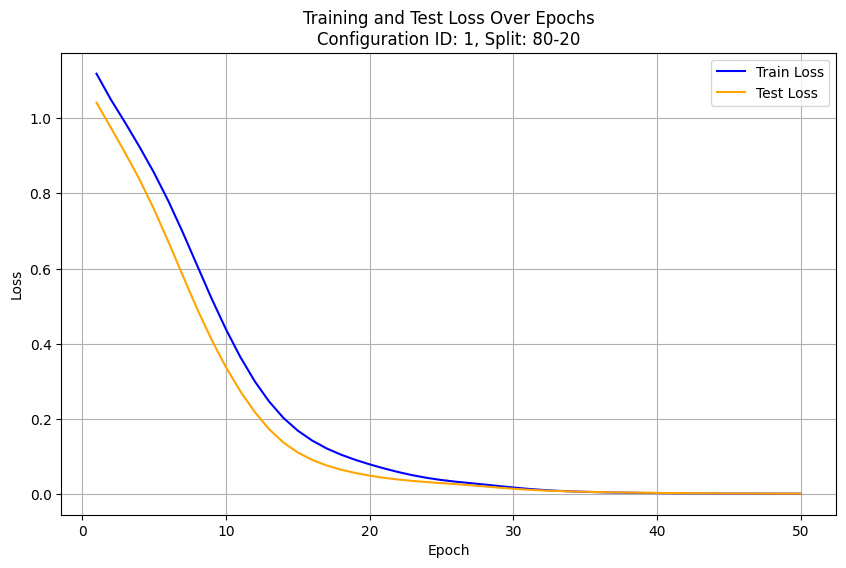

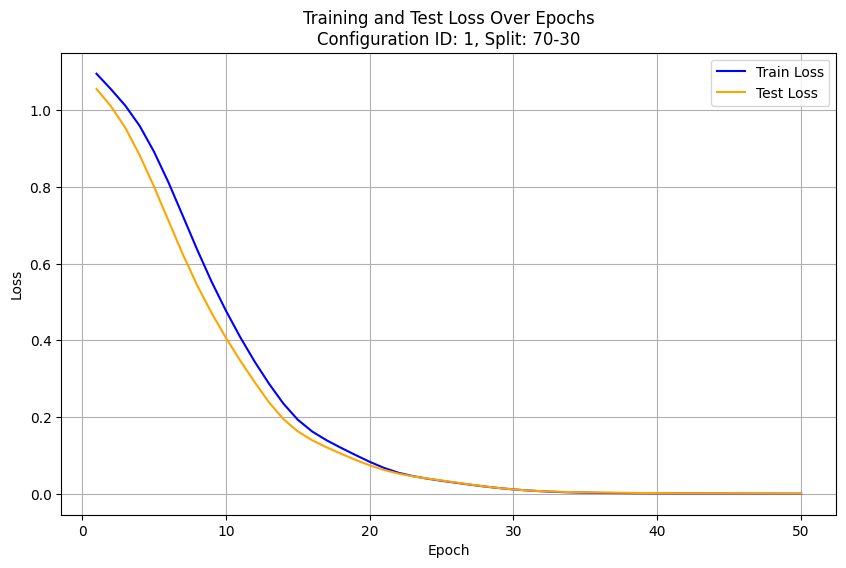

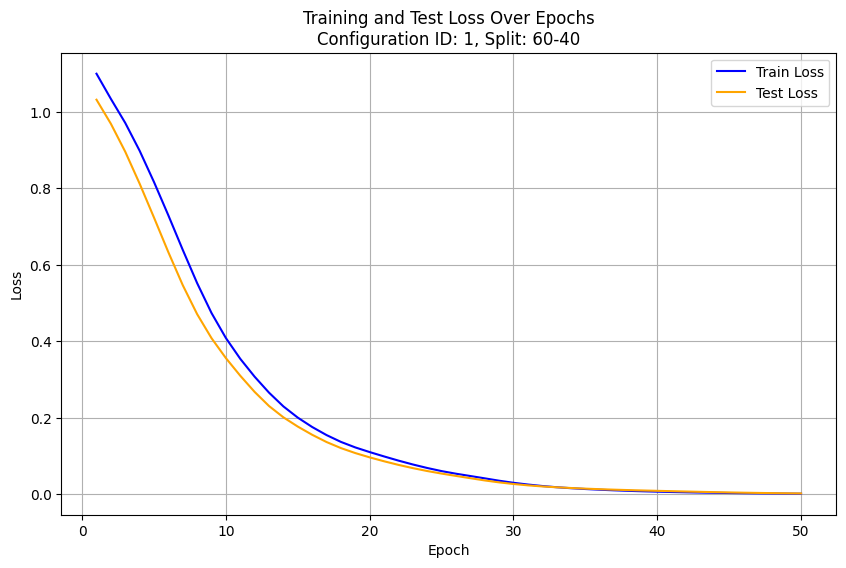

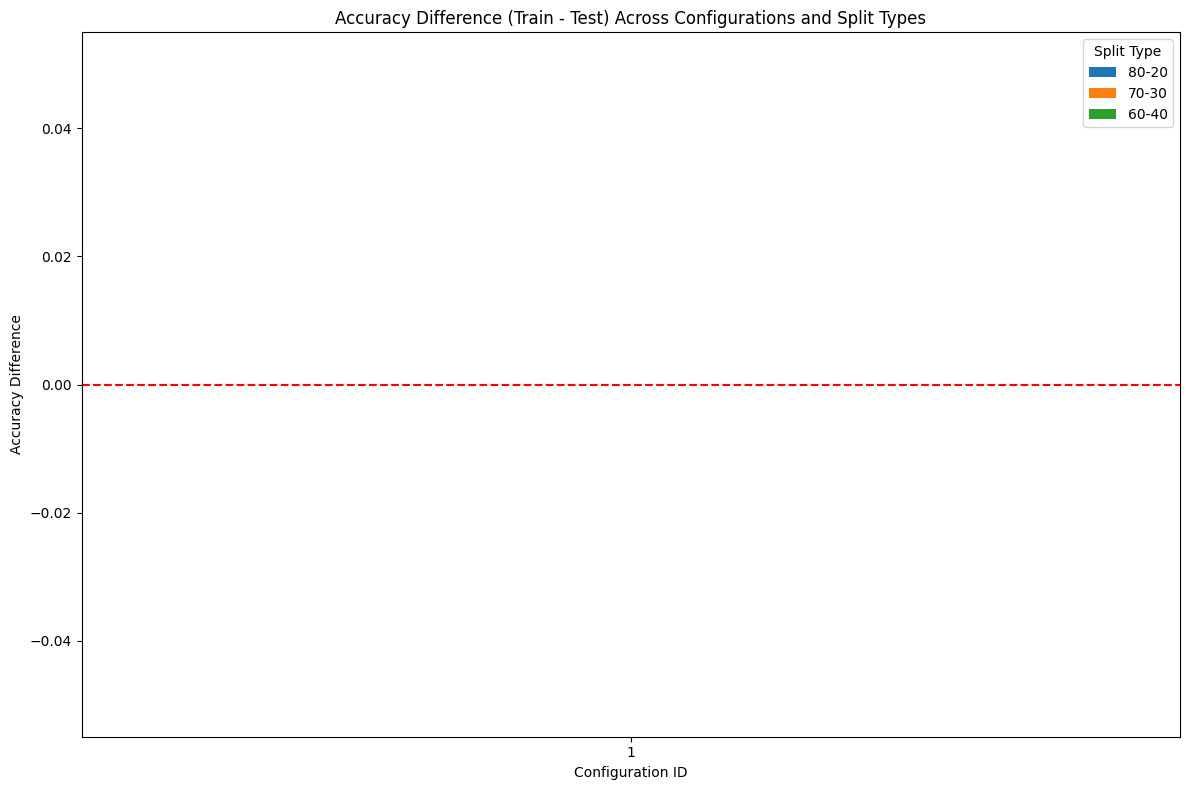

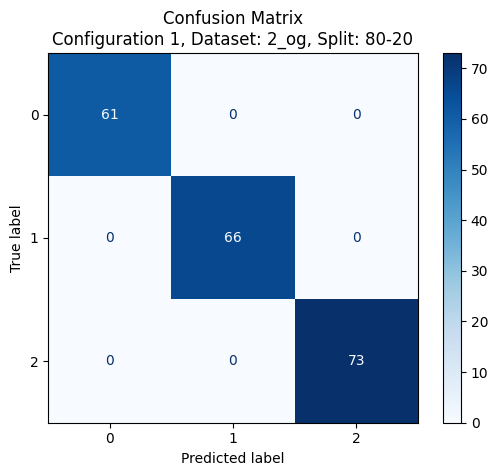

In [ ]:
# %%
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import os

# %%
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# %%
# Function to load and preprocess data for multi-class classification
def load_and_preprocess_data(file_path, target_column='Level'):
    """
    Load and preprocess the dataset for multi-class classification.

    Args:
        file_path (str): Path to the CSV file.
        target_column (str): Name of the target column.

    Returns:
        X_tensor (torch.Tensor): Features tensor.
        y_tensor (torch.Tensor): Labels tensor.
        num_classes (int): Number of unique classes.
    """
    df = pd.read_csv(file_path)
    X = df.drop(columns=[target_column]).values
    y = df[target_column].values

    # Map unique labels to integers
    unique_labels = np.unique(y)
    label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
    y_mapped = np.array([label_mapping[label] for label in y])

    num_classes = len(unique_labels)

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Convert to torch tensors
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y_mapped, dtype=torch.long).to(device)

    return X_tensor, y_tensor, num_classes

# %%
# Define a configurable MLP architecture with PyTorch for multi-class classification
class ConfigurableMLP(nn.Module):
    def __init__(self, input_dim, hidden_layers, activation, num_classes):
        super(ConfigurableMLP, self).__init__()
        layers = []
        prev_dim = input_dim
        for neurons in hidden_layers:
            layers.append(nn.Linear(prev_dim, neurons))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            else:
                raise ValueError(f"Unsupported activation function: {activation}")
            prev_dim = neurons
        layers.append(nn.Linear(prev_dim, num_classes))  # Output layer
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# %%
# Function to compute comprehensive metrics for multi-class classification
def compute_metrics(y_true, y_pred, y_prob, num_classes):
    """
    Compute various classification metrics for multi-class classification.

    Args:
        y_true (np.array): True labels.
        y_pred (np.array): Predicted labels.
        y_prob (np.array): Predicted probabilities.
        num_classes (int): Number of classes.

    Returns:
        dict: Dictionary containing all metrics.
    """
    metrics = {}
    metrics['Accuracy'] = accuracy_score(y_true, y_pred)
    metrics['Precision'] = precision_score(y_true, y_pred, average='macro', zero_division=0)
    metrics['Recall'] = recall_score(y_true, y_pred, average='macro', zero_division=0)
    metrics['F1 Score'] = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    # Compute AUC with one-vs-rest
    try:
        auc = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
    except ValueError:
        auc = np.nan  # Undefined if only one class present
    metrics['AUC'] = auc
    
    return metrics

# %%
# List of dataset paths to evaluate (Multi-class datasets)
dataset_paths = [
    r'/media/abood/windowsdatassd2/coursework/datasets/2_categorical/processed/2_nrml.csv',  # Dataset 2: Labels [0, 0.5, 1]
    r'/media/abood/windowsdatassd2/coursework/datasets/2_categorical/processed/2_og.csv'     # Dataset 3: Labels [1, 2, 3]
]

# Define hyperparameter grid for multi-class classification
param_grid = {
    'dataset_path': dataset_paths,
    'hidden_layers': [
        [23], [23, 23], [23, 23, 23], [23, 23, 23, 23], [23, 23, 23, 23, 23]
    ],
    'learning_rate': [0.001, 0.01, 0.1],
    'activation': ['relu', 'tanh'],
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'epochs': [10, 25, 50],
}

# Initialize a list to store all experimental results
results = []

# Initialize Stratified K-Fold Cross-Validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# %%
# Hyperparameter Grid Search for Multi-class Classification
for dataset_path in param_grid['dataset_path']:
    for hidden_layers in param_grid['hidden_layers']:
        for learning_rate in param_grid['learning_rate']:
            for activation in param_grid['activation']:
                for optimizer_name in param_grid['optimizer']:
                    for epoch in param_grid['epochs']:
                        f1_scores = []
                        dataset_name = os.path.basename(dataset_path)
                        
                        # Load and preprocess data for the current dataset
                        X_tensor, y_tensor, num_classes = load_and_preprocess_data(dataset_path, target_column='Level')
                        X = X_tensor.cpu().numpy()
                        y = y_tensor.cpu().numpy()
                        
                        # Perform K-Fold Cross-Validation
                        for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y), 1):
                            X_train_fold, X_val_fold = X_tensor[train_idx], X_tensor[val_idx]
                            y_train_fold, y_val_fold = y_tensor[train_idx], y_tensor[val_idx]

                            # Build the model
                            model = ConfigurableMLP(
                                input_dim=X_train_fold.shape[1], 
                                hidden_layers=hidden_layers, 
                                activation=activation, 
                                num_classes=num_classes
                            ).to(device)
                            
                            # Define optimizer
                            if optimizer_name == 'adam':
                                optimizer = optim.Adam(model.parameters(), lr=learning_rate)
                            elif optimizer_name == 'sgd':
                                optimizer = optim.SGD(model.parameters(), lr=learning_rate)
                            elif optimizer_name == 'rmsprop':
                                optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
                            else:
                                raise ValueError(f"Unsupported optimizer: {optimizer_name}")
                            
                            # Define loss function (CrossEntropyLoss for multi-class)
                            criterion = nn.CrossEntropyLoss()
                            
                            # Training loop
                            model.train()
                            for epoch_num in range(1, epoch + 1):
                                optimizer.zero_grad()
                                outputs = model(X_train_fold)
                                loss = criterion(outputs, y_train_fold)
                                loss.backward()
                                optimizer.step()
                            
                            # Evaluate the model on validation set
                            model.eval()
                            with torch.no_grad():
                                outputs_val = model(X_val_fold)
                                _, preds_val = torch.max(outputs_val, 1)
                            f1 = f1_score(y_val_fold.cpu().numpy(), preds_val.cpu().numpy(), average='macro', zero_division=0)
                            f1_scores.append(f1)

                        # Record the average F1-score for every configuration
                        avg_f1 = np.mean(f1_scores)
                        results.append({
                            'dataset': dataset_name,
                            'hidden_layers': hidden_layers,
                            'learning_rate': learning_rate,
                            'activation': activation,
                            'optimizer': optimizer_name,
                            'epochs': epoch,
                            'avg_f1_score': avg_f1
                        })

# %%
# Convert results to a pandas DataFrame for analysis
results_df = pd.DataFrame(results)

# Sort by F1-score to identify the top 3 best configurations
top_config = results_df.sort_values(by='avg_f1_score', ascending=False).head(1).reset_index(drop=True)
print(top_config)

# %%
# Save the entire hyperparameter search results to a CSV file
results_df.to_csv('hyperparameter_search_results_multiclass.csv', index=False)

# %%
# Analysis of various hyperparameters vs F1 Score

# 1. Number of Hidden Layers vs F1 Score
results_df['num_hidden_layers'] = results_df['hidden_layers'].apply(len)
hidden_layer_f1 = results_df.groupby('num_hidden_layers')['avg_f1_score'].mean()
plt.figure(figsize=(10, 6))
plt.plot(hidden_layer_f1.index, hidden_layer_f1.values, marker='o', linestyle='-')
plt.title('Number of Hidden Layers vs Average F1 Score')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Average F1 Score')
plt.grid(True)
plt.show()

print("\nAverage F1-Score by Number of Hidden Layers:")
print(hidden_layer_f1.reset_index().to_string(index=False))

# 2. Dataset vs F1 Score
dataset_analysis = results_df.groupby('dataset')['avg_f1_score'].mean().reset_index()
plt.figure(figsize=(10, 6))
bars = plt.bar(dataset_analysis['dataset'], dataset_analysis['avg_f1_score'], color='skyblue')
plt.title("Average F1-Score by Dataset")
plt.xlabel("Dataset")
plt.ylabel("Average F1-Score")
plt.grid(axis='y')
plt.show()

print("\nAverage F1-Score by Dataset:")
print(dataset_analysis.to_string(index=False))

# 3. Learning Rate vs F1 Score
learning_rate_f1 = results_df.groupby('learning_rate')['avg_f1_score'].mean()
plt.figure(figsize=(10, 6))
plt.plot(learning_rate_f1.index, learning_rate_f1.values, marker='o', linestyle='-')
plt.title('Learning Rate vs Average F1 Score')
plt.xlabel('Learning Rate')
plt.ylabel('Average F1 Score')
plt.xscale('log')
plt.grid(True)
plt.show()

print("\nAverage F1-Score by Learning Rate:")
print(learning_rate_f1.reset_index().to_string(index=False))

# 4. Activation Function vs F1 Score
activation_f1 = results_df.groupby('activation')['avg_f1_score'].mean()
plt.figure(figsize=(10, 6))
activation_f1.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Activation Function vs Average F1 Score')
plt.xlabel('Activation Function')
plt.ylabel('Average F1 Score')
plt.grid(axis='y')
plt.show()

print("\nAverage F1-Score by Activation Function:")
print(activation_f1.reset_index().to_string(index=False))

# 5. Optimizer vs F1 Score
optimizer_f1 = results_df.groupby('optimizer')['avg_f1_score'].mean()
plt.figure(figsize=(10, 6))
optimizer_f1.plot(kind='bar', color='salmon', edgecolor='black')
plt.title('Optimizer vs Average F1 Score')
plt.xlabel('Optimizer')
plt.ylabel('Average F1 Score')
plt.grid(axis='y')
plt.show()

print("\nAverage F1-Score by Optimizer:")
print(optimizer_f1.reset_index().to_string(index=False))

# 6. Number of Epochs vs F1 Score
epochs_analysis = results_df.groupby('epochs')['avg_f1_score'].mean().reset_index()
plt.figure(figsize=(10, 6))
plt.bar(epochs_analysis['epochs'].astype(str), epochs_analysis['avg_f1_score'], color='skyblue')
plt.title("Average F1-Score by Number of Epochs")
plt.xlabel("Number of Epochs")
plt.ylabel("Average F1-Score")
plt.grid(axis='y')
plt.show()

print("\nAverage F1-Score by Number of Epochs:")
print(epochs_analysis.to_string(index=False))

# %%
# Hyperparameter Search Results: Top 3 Configurations
print("\nTop 3 Configurations based on Average F1-Score:")
print(top_config.to_string(index=False))

# %%
# Save top configurations to a separate CSV
top_config.to_csv('top_3_configurations_multiclass.csv', index=False)

# %%
# Analysis of top 3 configurations on different train-test splits with confusion matrices

# Load the top 3 configurations
top_3_df = pd.read_csv('top_3_configurations_multiclass.csv')

# Initialize a list to store all experimental results
experiment_results = []

# Define the different train-test splits
split_ratios = {
    '80-20': {'train_size': 0.8, 'test_size': 0.2},
    '70-30': {'train_size': 0.7, 'test_size': 0.3},
    '60-40': {'train_size': 0.6, 'test_size': 0.4},
}

# %%
# Iterate over the top 3 configurations
for idx, config in top_3_df.iterrows():
    config_id = idx + 1 
    hidden_layers = ast.literal_eval(config['hidden_layers']) if isinstance(config['hidden_layers'], str) else config['hidden_layers']
    learning_rate = config['learning_rate']
    activation = config['activation']
    optimizer_name = config['optimizer']
    epochs = config['epochs']
    dataset_path = config['dataset']
    dataset_directory = '/media/abood/windowsdatassd2/coursework/datasets/2_categorical/processed'
    dataset_full_path = os.path.join(dataset_directory, dataset_path)

    if not os.path.isfile(dataset_full_path):
        print(f"Dataset file '{dataset_full_path}' does not exist. Skipping Configuration {config_id}.")
        continue

    dataset_name = os.path.basename(dataset_path).replace('.csv', '')
    
    # Load and preprocess data
    X_tensor, y_tensor, num_classes = load_and_preprocess_data(dataset_full_path, target_column='Level')
    X = X_tensor.cpu().numpy()
    y = y_tensor.cpu().numpy()
    
    # Loop through different split types
    for split_type, ratios in split_ratios.items():
        
        # Perform train-test split
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
            X, y,
            train_size=ratios['train_size'], test_size=ratios['test_size'],
            stratify=y, random_state=42
        )
        
        # Convert back to torch tensors
        X_train_split = torch.tensor(X_train_split, dtype=torch.float32).to(device)
        y_train_split = torch.tensor(y_train_split, dtype=torch.long).to(device)
        X_test_split = torch.tensor(X_test_split, dtype=torch.float32).to(device)
        y_test_split = torch.tensor(y_test_split, dtype=torch.long).to(device)
        
        # Initialize the model
        model = ConfigurableMLP(
            input_dim=X_train_split.shape[1], 
            hidden_layers=hidden_layers, 
            activation=activation, 
            num_classes=num_classes
        ).to(device)
        
        # Define optimizer
        if optimizer_name.lower() == 'adam':
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        elif optimizer_name.lower() == 'sgd':
            optimizer = optim.SGD(model.parameters(), lr=learning_rate)
        elif optimizer_name.lower() == 'rmsprop':
            optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
        else:
            print(f"Unsupported optimizer: {optimizer_name}. Skipping this split.")
            continue

        # Define loss function (CrossEntropyLoss for multi-class)
        criterion = nn.CrossEntropyLoss()
        
        # Initialize lists to store losses for this split
        train_losses = []
        test_losses = []
        
        # Training loop
        model.train()
        for epoch_num in range(1, epochs + 1):
            optimizer.zero_grad()
            outputs = model(X_train_split)
            loss = criterion(outputs, y_train_split)
            loss.backward()
            optimizer.step()

            # Record training loss
            train_losses.append(loss.item())
        
            # Evaluate on test set
            model.eval()
            with torch.no_grad():
                outputs_test = model(X_test_split)
                loss_test = criterion(outputs_test, y_test_split).item()
                test_losses.append(loss_test)
            
            # Return to training mode
            model.train()

        # Evaluate the model on training set
        model.eval()
        with torch.no_grad():
            outputs_train = model(X_train_split)
            _, preds_train = torch.max(outputs_train, 1)
            y_train_pred = preds_train.cpu().numpy()
            y_train_prob = torch.softmax(outputs_train, dim=1).cpu().numpy()
        
        # Evaluate the model on test set
        with torch.no_grad():
            outputs_test = model(X_test_split)
            _, preds_test = torch.max(outputs_test, 1)
            y_test_pred = preds_test.cpu().numpy()
            y_test_prob = torch.softmax(outputs_test, dim=1).cpu().numpy()
        
        # Compute metrics
        train_metrics = compute_metrics(y_train_split.cpu().numpy(), y_train_pred, y_train_prob, num_classes)
        test_metrics = compute_metrics(y_test_split.cpu().numpy(), y_test_pred, y_test_prob, num_classes)
        
        # Record the results
        experiment_results.append({
            'Configuration_ID': config_id,
            'Dataset': dataset_name,
            'Hidden_Layers': hidden_layers,
            'Learning_Rate': learning_rate,
            'Activation': activation,
            'Optimizer': optimizer_name,
            'Epochs': epochs,
            'Split_Type': split_type,
            'Train_Accuracy': train_metrics['Accuracy'],
            'Train_Precision': train_metrics['Precision'],
            'Train_Recall': train_metrics['Recall'],
            'Train_F1_Score': train_metrics['F1 Score'],
            'Train_AUC': train_metrics['AUC'],
            'Test_Accuracy': test_metrics['Accuracy'],
            'Test_Precision': test_metrics['Precision'],
            'Test_Recall': test_metrics['Recall'],
            'Test_F1_Score': test_metrics['F1 Score'],
            'Test_AUC': test_metrics['AUC'],
            'y_test': y_test_split.cpu().numpy().tolist(),
            'y_pred': y_test_pred.tolist()
        })

        # Plot Training and Test Loss Over Epochs for this split
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='blue')
        plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', color='orange')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Training and Test Loss Over Epochs\nConfiguration ID: {config_id}, Split: {split_type}')
        plt.legend()
        plt.grid(True)
        plt.show()

# %%
# Convert the experiment results to a pandas DataFrame for further analysis
all_results_df = pd.DataFrame(experiment_results)

# %%
# Save the entire results DataFrame to a CSV file
final_output_csv_path = '/media/abood/windowsdatassd2/coursework/R5(Neural Networks)/final_experiment_results_multiclass.csv'
all_results_df.to_csv(final_output_csv_path, index=False)

# %%
# Calculate the difference between Train and Test Accuracy
all_results_df['Accuracy_Difference'] = all_results_df['Train_Accuracy'] - all_results_df['Test_Accuracy']



# %%
# Confusion Matrix Analysis for 80-20 Split

# Filter the DataFrame for the 80-20 split
split_type_of_interest = '80-20'
split_df = all_results_df[all_results_df['Split_Type'] == split_type_of_interest]

# Check if 'y_test' and 'y_pred' columns exist
if 'y_test' not in split_df.columns or 'y_pred' not in split_df.columns:
    raise KeyError("The DataFrame does not contain 'y_test' and 'y_pred' columns. "
                   "Please ensure these are stored during the experiment.")

# Iterate over each configuration in the 80-20 split and plot the confusion matrix
for idx, row in split_df.iterrows():
    config_id = row['Configuration_ID']
    dataset_name = row['Dataset']
    
    # Retrieve 'y_test' and 'y_pred'
    y_true = row['y_test']
    y_pred = row['y_pred']
    
    # Convert string representations of lists to actual lists if necessary
    if isinstance(y_true, str):
        y_true = ast.literal_eval(y_true)
    if isinstance(y_pred, str):
        y_pred = ast.literal_eval(y_pred)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create confusion matrix display
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(np.unique(y_true)))
    
    # Plot the confusion matrix
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(f'Confusion Matrix\nConfiguration {config_id}, Dataset: {dataset_name}, Split: {split_type_of_interest}')
    plt.show()


Using device: cuda
Testing config 1/810: Dataset=1_ef_b.csv, Layers=[15], LR=0.001, Activation=relu, Optimizer=adam, Epochs=10
Average F1-Score: 0.7151471377711118

Testing config 2/810: Dataset=1_ef_b.csv, Layers=[15], LR=0.001, Activation=relu, Optimizer=adam, Epochs=25
Average F1-Score: 0.44468758294845256

Testing config 3/810: Dataset=1_ef_b.csv, Layers=[15], LR=0.001, Activation=relu, Optimizer=adam, Epochs=50
Average F1-Score: 0.7573352475613232

Testing config 4/810: Dataset=1_ef_b.csv, Layers=[15], LR=0.001, Activation=relu, Optimizer=sgd, Epochs=10
Average F1-Score: 0.3392157330132663

Testing config 5/810: Dataset=1_ef_b.csv, Layers=[15], LR=0.001, Activation=relu, Optimizer=sgd, Epochs=25
Average F1-Score: 0.36785074731647044

Testing config 6/810: Dataset=1_ef_b.csv, Layers=[15], LR=0.001, Activation=relu, Optimizer=sgd, Epochs=50
Average F1-Score: 0.4416055893833833

Testing config 7/810: Dataset=1_ef_b.csv, Layers=[15], LR=0.001, Activation=relu, Optimizer=rmsprop, Epoch

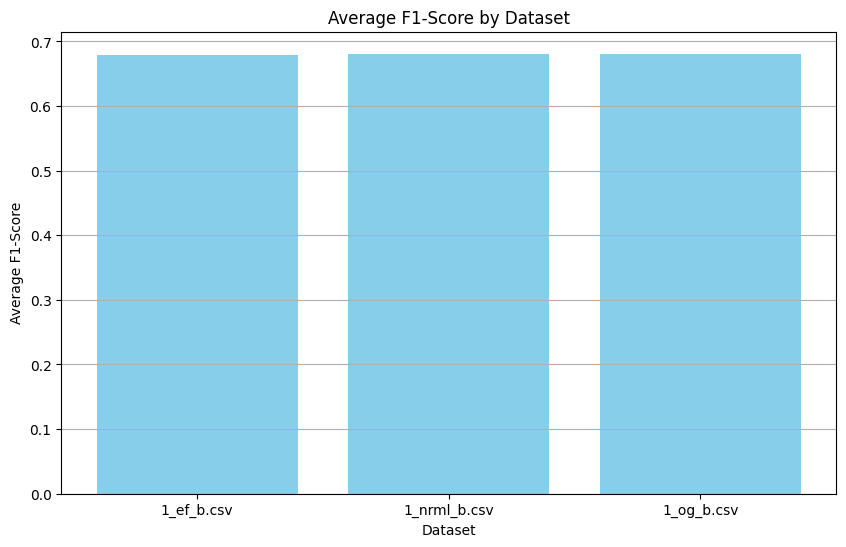

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Function to load and preprocess data
def load_and_preprocess_data(file_path, test_size=0.2):
    df = pd.read_csv(file_path)
    X = df.drop(columns=['LUNG_CANCER']).values
    y = df['LUNG_CANCER'].values

    # Check if labels are 1 and 2, and map to 0 and 1 if needed
    if set(np.unique(y)) == {1, 2}:
        y = np.where(y == 1, 0, 1)

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42)

    # Convert to torch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

    return X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor

# Define a configurable MLP architecture with PyTorch
class ConfigurableMLP(nn.Module):
    def __init__(self, input_dim, hidden_layers, activation):
        super(ConfigurableMLP, self).__init__()
        layers = []
        prev_dim = input_dim
        for neurons in hidden_layers:
            layers.append(nn.Linear(prev_dim, neurons))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            prev_dim = neurons
        layers.append(nn.Linear(prev_dim, 1))  # Output layer
        layers.append(nn.Sigmoid())  # Binary classification
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        """
        Args:
            patience (int): How many epochs to wait after last improvement.
            verbose (bool): If True, prints a message for each improvement.
            delta (float): Minimum change to qualify as an improvement.
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, score, model):
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

# List of dataset paths to evaluate
dataset_paths = [
    r'/media/abood/windowsdatassd2/coursework/datasets/1_binary/processed/1_ef_b.csv',
    r'/media/abood/windowsdatassd2/coursework/datasets/1_binary/processed/1_nrml_b.csv',
    r'/media/abood/windowsdatassd2/coursework/datasets/1_binary/processed/1_og_b.csv'
]

# Define hyperparameter grid including 'dataset_path'
param_grid = {
    'dataset_path': dataset_paths,  # Added dataset paths
    'hidden_layers': [
        [15], [15, 15], [15, 15, 15], [15, 15, 15, 15], [15, 15, 15, 15, 15]
    ],
    'learning_rate': [0.001, 0.01, 0.1],
    'activation': ['relu', 'tanh'],
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'epochs': [10, 25, 50],  # Updated epoch options
}

# Fixed parameters
batch_size = 32  # Not used in current implementation but kept for reference

# Perform grid search
results = []
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Calculate total number of configurations for progress tracking
total_configs = len(param_grid['dataset_path']) * len(param_grid['hidden_layers']) * len(param_grid['learning_rate']) * \
               len(param_grid['activation']) * len(param_grid['optimizer']) * len(param_grid['epochs'])
current_config = 1

for dataset_path in param_grid['dataset_path']:
    for hidden_layers in param_grid['hidden_layers']:
        for learning_rate in param_grid['learning_rate']:
            for activation in param_grid['activation']:
                for optimizer_name in param_grid['optimizer']:
                    for epoch in param_grid['epochs']:
                        f1_scores = []
                        dataset_name = dataset_path.split('/')[-1]
                        print(f"Testing config {current_config}/{total_configs}: "
                              f"Dataset={dataset_name}, Layers={hidden_layers}, LR={learning_rate}, "
                              f"Activation={activation}, Optimizer={optimizer_name}, Epochs={epoch}")
                        
                        # Load and preprocess data for the current dataset
                        X_train, X_test, y_train, y_test = load_and_preprocess_data(dataset_path)
                        
                        # Perform Stratified K-Fold Cross-Validation
                        for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train.cpu().numpy(), y_train.cpu().numpy().ravel()), 1):
                            X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
                            y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

                            # Build the model
                            model = ConfigurableMLP(input_dim=X_train.shape[1], hidden_layers=hidden_layers, activation=activation).to(device)
                            
                            # Define optimizer
                            if optimizer_name == 'adam':
                                optimizer = optim.Adam(model.parameters(), lr=learning_rate)
                            elif optimizer_name == 'sgd':
                                optimizer = optim.SGD(model.parameters(), lr=learning_rate)
                            elif optimizer_name == 'rmsprop':
                                optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
                            
                            # Define loss function
                            criterion = nn.BCELoss()

                            # Initialize Early Stopping
                            early_stopping = EarlyStopping(patience=10, verbose=False)

                            # Training loop with Early Stopping
                            model.train()
                            for epoch_num in range(1, epoch + 1):
                                optimizer.zero_grad()
                                y_pred = model(X_train_fold)
                                loss = criterion(y_pred, y_train_fold)
                                loss.backward()
                                optimizer.step()

                                # Evaluate on validation fold
                                model.eval()
                                with torch.no_grad():
                                    y_val_pred_prob = model(X_val_fold)
                                    val_loss = criterion(y_val_pred_prob, y_val_fold).item()
                                
                                # Call Early Stopping
                                early_stopping(val_loss, model)
                                
                                if early_stopping.early_stop:
                                    if early_stopping.verbose:
                                        print(f"Early stopping at epoch {epoch_num}")
                                    break
                                
                                model.train()
                            
                            # Load the best model state
                            if early_stopping.best_model_state is not None:
                                model.load_state_dict(early_stopping.best_model_state)
                            
                            # Evaluate the model
                            model.eval()
                            with torch.no_grad():
                                y_val_pred = (model(X_val_fold) > 0.5).cpu().numpy().astype(int)
                            f1 = f1_score(y_val_fold.cpu().numpy(), y_val_pred, zero_division=0)
                            f1_scores.append(f1)

                        # Record the average F1-score for this configuration
                        avg_f1 = np.mean(f1_scores)
                        results.append({
                            'dataset': dataset_name,
                            'hidden_layers': hidden_layers,
                            'learning_rate': learning_rate,
                            'activation': activation,
                            'optimizer': optimizer_name,
                            'epochs': epoch,
                            'avg_f1_score': avg_f1
                        })
                        print(f"Average F1-Score: {avg_f1}\n")
                        current_config += 1

# Convert results to a DataFrame for analysis
results_df = pd.DataFrame(results)

# Sort by F1-score to identify the best configuration
best_config = results_df.sort_values(by='avg_f1_score', ascending=False).iloc[0]
print("\nBest Configuration:")
print(best_config)

In [6]:
results_df.head()

,dataset,hidden_layers,learning_rate,activation,optimizer,epochs,avg_f1_score
0,1_ef_b.csv,[15],0.001,relu,adam,10,0.715147
1,1_ef_b.csv,[15],0.001,relu,adam,25,0.444688
2,1_ef_b.csv,[15],0.001,relu,adam,50,0.757335
3,1_ef_b.csv,[15],0.001,relu,sgd,10,0.339216
4,1_ef_b.csv,[15],0.001,relu,sgd,25,0.367851


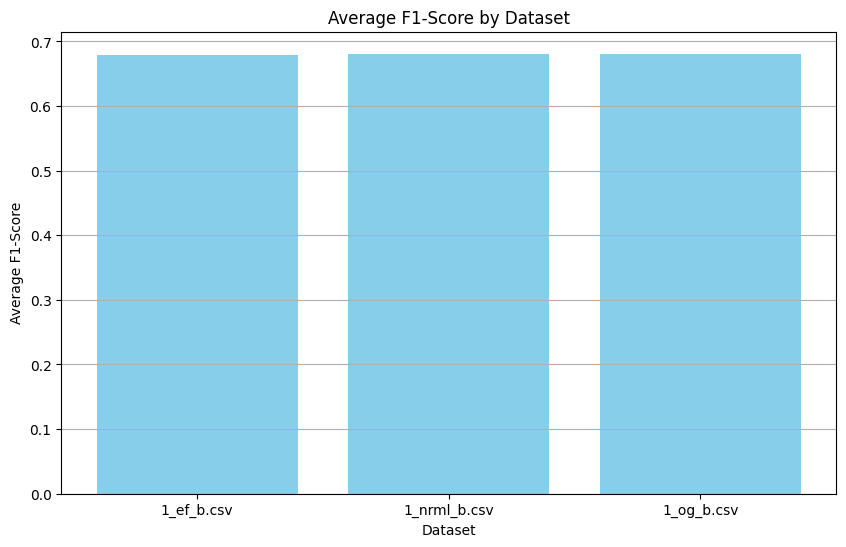


Average F1-Score by Dataset:
     dataset  avg_f1_score
  1_ef_b.csv      0.678925
1_nrml_b.csv      0.680994
  1_og_b.csv      0.681034


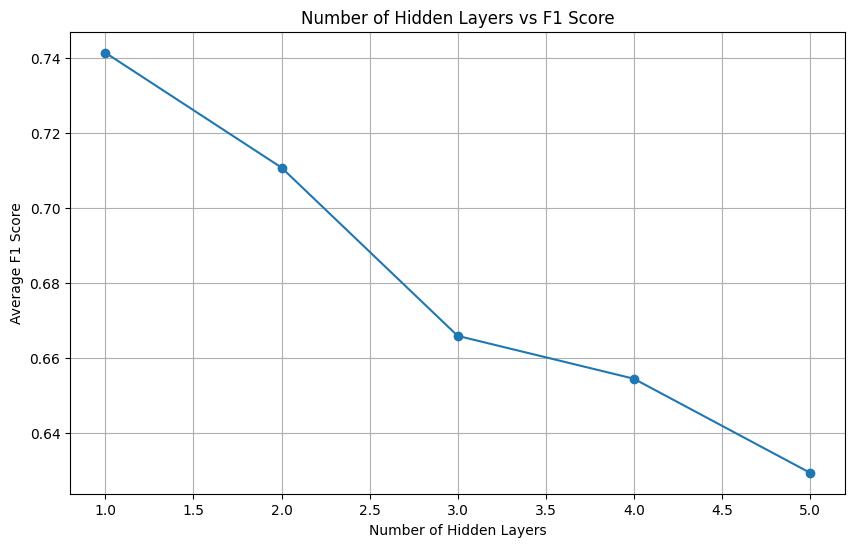


Average F1-Score by Number of Hidden Layers:
 num_hidden_layers  avg_f1_score
                 1      0.741295
                 2      0.710679
                 3      0.665836
                 4      0.654418
                 5      0.629360


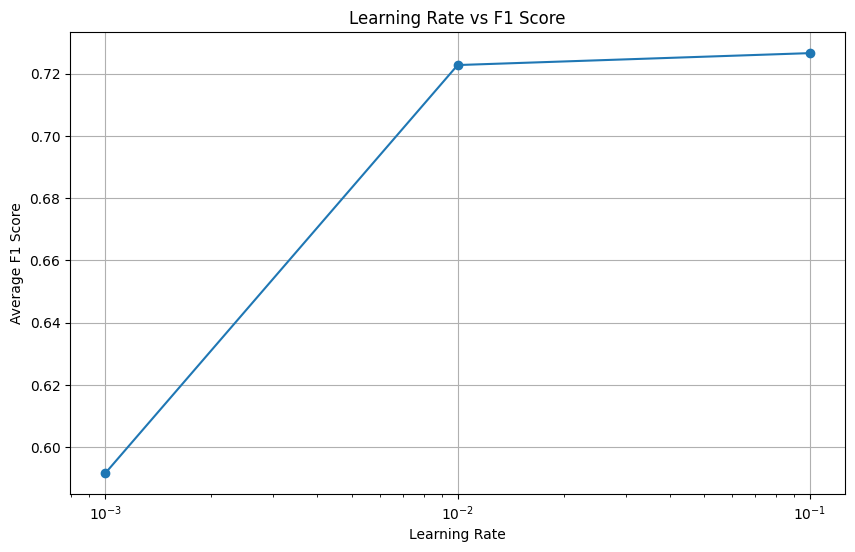


Average F1-Score by Learning Rate:
 learning_rate  avg_f1_score
         0.001      0.591637
         0.010      0.722741
         0.100      0.726574


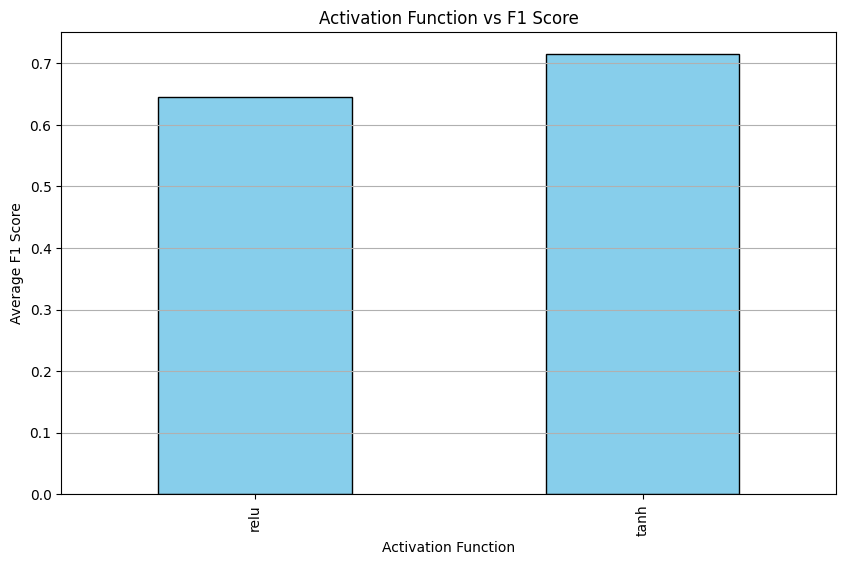


Average F1-Score by Activation Function:
activation  avg_f1_score
      relu      0.645430
      tanh      0.715205


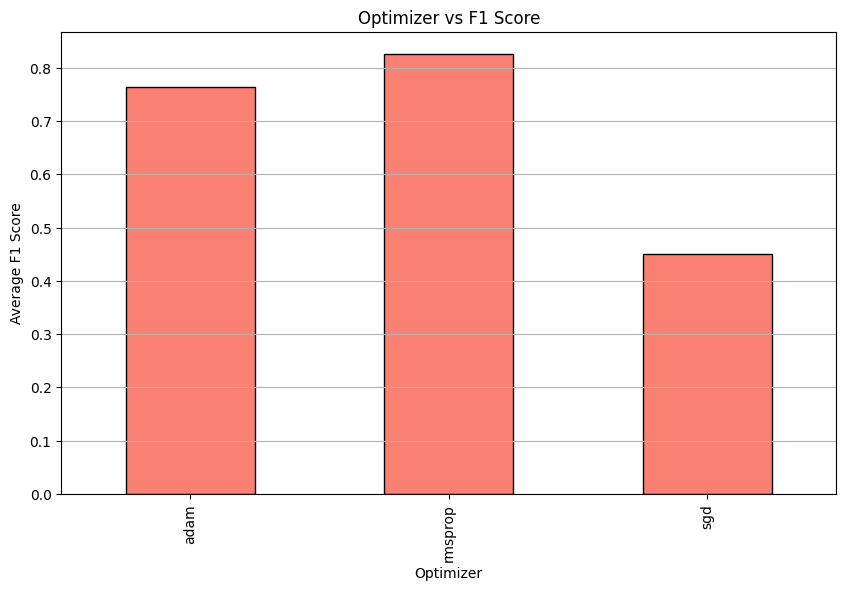


Average F1-Score by Optimizer:
optimizer  avg_f1_score
     adam      0.764747
  rmsprop      0.826114
      sgd      0.450091


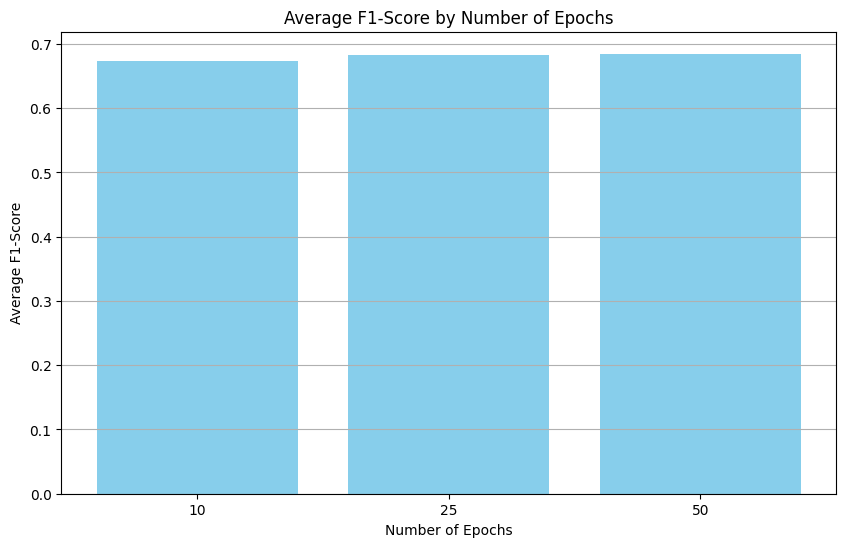


Average F1-Score by Number of Epochs:
 epochs  avg_f1_score
     10      0.673039
     25      0.683184
     50      0.684729


In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `results_df` is your DataFrame containing the results
# Ensure results_df is already defined and populated with your hyperparameter search results



# Analyze the effect of datasets
dataset_analysis = results_df.groupby('dataset')['avg_f1_score'].mean().reset_index()

plt.figure(figsize=(10, 6))
bars = plt.bar(dataset_analysis['dataset'], dataset_analysis['avg_f1_score'], color='skyblue')

plt.title("Average F1-Score by Dataset")
plt.xlabel("Dataset")
plt.ylabel("Average F1-Score")
plt.grid(axis='y')

plt.show()


print("\nAverage F1-Score by Dataset:")
print(dataset_analysis.to_string(index=False))


# Calculate the number of hidden layers for each configuration
results_df['num_hidden_layers'] = results_df['hidden_layers'].apply(len)

# Group by the number of hidden layers and compute the mean F1 score
hidden_layer_f1 = results_df.groupby('num_hidden_layers')['avg_f1_score'].mean()

# Plot: Number of Hidden Layers vs F1 Score
plt.figure(figsize=(10, 6))
plt.plot(hidden_layer_f1.index, hidden_layer_f1.values, marker='o', linestyle='-')
plt.title('Number of Hidden Layers vs F1 Score')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Average F1 Score')
plt.grid(True)
plt.show()


print("\nAverage F1-Score by Number of Hidden Layers:")
print(hidden_layer_f1.reset_index().to_string(index=False))

# Plot: Learning Rate vs F1 Score
learning_rate_f1 = results_df.groupby('learning_rate')['avg_f1_score'].mean()
plt.figure(figsize=(10, 6))
plt.plot(learning_rate_f1.index, learning_rate_f1.values, marker='o', linestyle='-')
plt.title('Learning Rate vs F1 Score')
plt.xlabel('Learning Rate')
plt.ylabel('Average F1 Score')
plt.xscale('log')  # Log scale for learning rate
plt.grid(True)
plt.show()

print("\nAverage F1-Score by Learning Rate:")
print(learning_rate_f1.reset_index().to_string(index=False))


# Plot: Activation Function vs F1 Score
activation_f1 = results_df.groupby('activation')['avg_f1_score'].mean()
plt.figure(figsize=(10, 6))
activation_f1.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Activation Function vs F1 Score')
plt.xlabel('Activation Function')
plt.ylabel('Average F1 Score')
plt.grid(axis='y')
plt.show()


print("\nAverage F1-Score by Activation Function:")
print(activation_f1.reset_index().to_string(index=False))

# Plot: Optimizer vs F1 Score
optimizer_f1 = results_df.groupby('optimizer')['avg_f1_score'].mean()
plt.figure(figsize=(10, 6))
optimizer_f1.plot(kind='bar', color='salmon', edgecolor='black')
plt.title('Optimizer vs F1 Score')
plt.xlabel('Optimizer')
plt.ylabel('Average F1 Score')
plt.grid(axis='y')
plt.show()

print("\nAverage F1-Score by Optimizer:")
print(optimizer_f1.reset_index().to_string(index=False))


# Analyze the effect of epochs
epochs_analysis = results_df.groupby('epochs')['avg_f1_score'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(epochs_analysis['epochs'].astype(str), epochs_analysis['avg_f1_score'], color='skyblue')
plt.title("Average F1-Score by Number of Epochs")
plt.xlabel("Number of Epochs")
plt.ylabel("Average F1-Score")
plt.grid(axis='y')
plt.show()

print("\nAverage F1-Score by Number of Epochs:")
print(epochs_analysis.to_string(index=False))

In [17]:
# Sort by F1-score to identify the best configurations
top_10_configs = results_df.sort_values(by='avg_f1_score', ascending=False).head(10)
print("\nTop 3 Configurations:")
print(top_10_configs)



Top 3 Configurations:
          dataset     hidden_layers  learning_rate activation optimizer  \
403  1_nrml_b.csv      [15, 15, 15]           0.01       relu   rmsprop   
618    1_og_b.csv          [15, 15]           0.01       relu   rmsprop   
619    1_og_b.csv          [15, 15]           0.01       relu   rmsprop   
361  1_nrml_b.csv          [15, 15]           0.10       relu      adam   
620    1_og_b.csv          [15, 15]           0.01       relu   rmsprop   
348  1_nrml_b.csv          [15, 15]           0.01       relu   rmsprop   
349  1_nrml_b.csv          [15, 15]           0.01       relu   rmsprop   
685    1_og_b.csv      [15, 15, 15]           0.10       relu      adam   
740    1_og_b.csv  [15, 15, 15, 15]           0.10       relu      adam   
593    1_og_b.csv              [15]           0.10       tanh   rmsprop   

     epochs  avg_f1_score  num_hidden_layers  
403      25      0.953366                  3  
618      10      0.951008                  2  
619      2